<a href="https://colab.research.google.com/github/bachsykhang/StockPredictVinamilk/blob/main/Vinamilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bước 1: Import thư viện

In [2]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [3]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dữ liệu train chứng khoán/FPT.csv')


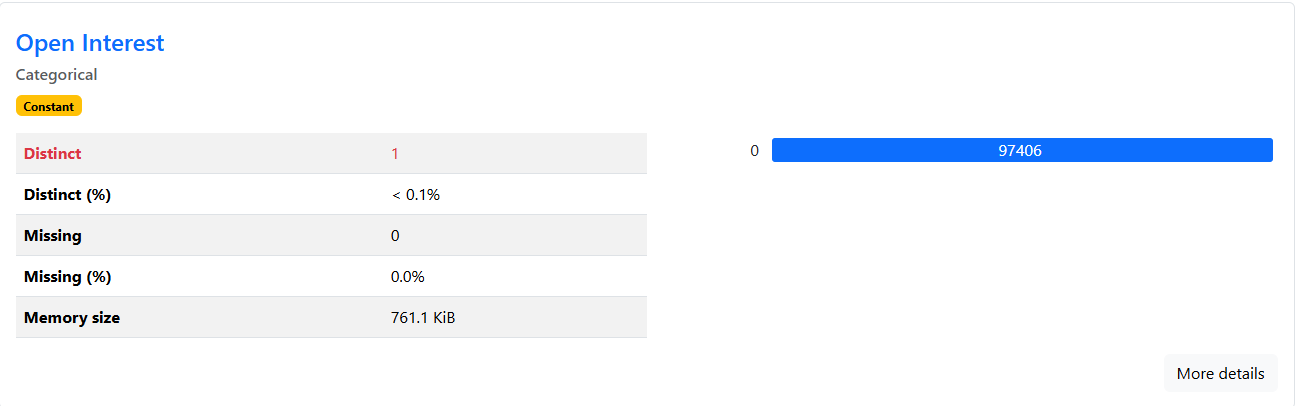

In [5]:
#xóa bỏ các cột không đóp góp nhiều
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

df=df.drop(['Ticker','Open Interest'],axis=1) # nhận xét ticker và open interest không đóng góp nhiều -> loại bỏ

# Hiển thị lại DataFrame sau khi xóa
print(df)

                Date/Time   Open   High    Low  Close  Volume
0     2018-12-25 09:15:00  30.89  30.89  30.89  30.89   35410
1     2018-12-25 09:16:00  30.81  30.81  30.81  30.81     190
2     2018-12-25 09:17:00  30.74  30.81  30.74  30.74    1120
3     2018-12-25 09:18:00  30.74  30.74  30.74  30.74    2120
4     2018-12-25 09:19:00  30.74  30.74  30.74  30.74   22500
...                   ...    ...    ...    ...    ...     ...
97401 2020-12-22 14:24:00  58.20  58.20  58.20  58.20   27470
97402 2020-12-22 14:25:00  58.20  58.20  58.20  58.20   14820
97403 2020-12-22 14:26:00  58.20  58.20  58.20  58.20     500
97404 2020-12-22 14:29:00  58.10  58.10  58.10  58.10    2500
97405 2020-12-22 14:46:00  58.10  58.10  58.10  58.10   11170

[97406 rows x 6 columns]


# Bước 3: Mô tả dữ liệu

In [6]:
#kích thước dữ liệu
df.shape

(97406, 6)

In [7]:
#dữ liệu 5 dòng đầu
df.head()

,Date/Time,Open,High,Low,Close,Volume
0,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [8]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date/Time  97406 non-null  datetime64[ns]
 1   Open       97406 non-null  float64       
 2   High       97406 non-null  float64       
 3   Low        97406 non-null  float64       
 4   Close      97406 non-null  float64       
 5   Volume     97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.5 MB


In [9]:
#mô tả bộ dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04


# Bước 4: Tiền xử lý dữ liệu

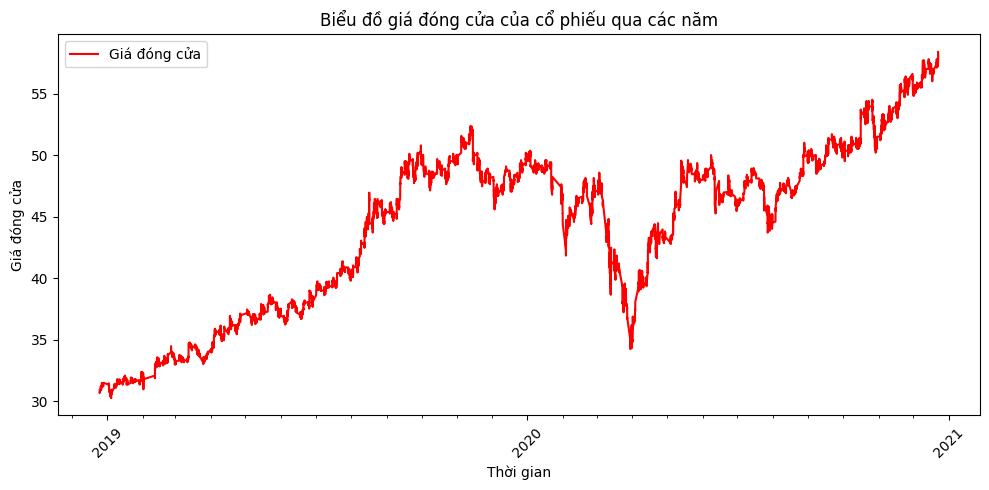

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

# Giả sử df là DataFrame của bạn, chuyển cột Date/Time sang datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')


# Lấy thông tin năm từ cột Date/Time
df['Năm'] = df['Date/Time'].dt.year

# Vẽ đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của cổ phiếu qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Khai báo MonthLocator

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
df1 = pd.DataFrame(df, columns=['Date/Time', 'Close'])
df1.index = df1['Date/Time']  # Sử dụng dấu [] để truy cập cột 'Date/Time'
df1.drop('Date/Time', axis=1, inplace=True)
df1


,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [12]:
#chia tập dữ liệu
data = df1.values
train_data = data[:57000] #60% cho tập train
test_data = data[57000:] #40% cho tập test

In [ ]:
data

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [58.2 ],
       [58.1 ],
       [58.1 ]])

In [13]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [14]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(100,len(train_data)):
  x_train.append(sc_train[i-100:i,0]) #lấy 100 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [15]:
x_train

[array([0.02273535, 0.01989343, 0.01740675, 0.01740675, 0.01740675,
        0.01740675, 0.01456483, 0.03055062, 0.03339254, 0.03339254,
        0.03197158, 0.03055062, 0.03055062, 0.03055062, 0.03339254,
        0.03339254, 0.03055062, 0.03445826, 0.03445826, 0.02806394,
        0.02806394, 0.02522202, 0.02522202, 0.02522202, 0.02522202,
        0.02273535, 0.02273535, 0.02522202, 0.02273535, 0.02273535,
        0.02522202, 0.02522202, 0.02806394, 0.03339254, 0.03055062,
        0.03197158, 0.03197158, 0.03055062, 0.03055062, 0.03055062,
        0.03055062, 0.03339254, 0.03339254, 0.03339254, 0.03055062,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.03197158,
        0.03197158, 0.03055062, 0.03197158, 0.03055062, 0.03197158,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.03055062,
        0.03197158, 0.03197158, 0.03197158, 0.03055062, 0.03055062,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.02912966,
        0.02912966, 0.02912966, 0.02912966, 0.02

In [16]:
y_train

[np.float64(0.026642984014209725),
 np.float64(0.028063943161634075),
 np.float64(0.026642984014209725),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.025222024866785153),
 np.float64(0.025222024866785153),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.028063943161634075),
 np.float64(0.029129662522202615),
 np.float64(0.025222024866785153),
 np.float64(0.025222024866785153),
 np.float64(0.029129662522202615),
 np.float64(0.029129662522202615),
 np.float64(0.025222024866785153),
 np.float64(0.024156305506216835),
 np.float64(0.024156305506216835),
 np.float64(0.025222024866785153),
 np.float64(0.024156305506216835),
 np.float64(0.025222024866785153),
 np.float64(0.025222024866785153),
 np.float64(0.024156305506216835),
 np.float64(0.024156

In [17]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 3 chiều,2 chiều đầu vào LSTM (sample, step, số lượng thông tin)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [18]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.02152, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 12s - 10ms/step - loss: 0.0215
Epoch 2/100

Epoch 2: loss improved from 0.02152 to 0.02126, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 11s - 9ms/step - loss: 0.0213
Epoch 3/100

Epoch 3: loss improved from 0.02126 to 0.02120, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 22s - 20ms/step - loss: 0.0212
Epoch 4/100

Epoch 4: loss improved from 0.02120 to 0.02082, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 10s - 9ms/step - loss: 0.0208
Epoch 5/100

Epoch 5: loss improved from 0.02082 to 0.02076, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 10s - 9ms/step - loss: 0.0208
Epoch 6/100

Epoch 6: loss did not improve from 0.02076
1138/1138 - 11s - 9ms/step - loss: 0.0208
Epoch 7/100

Epoch 7: loss improved from 0.02076 to 0.02064, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 21s - 18ms/step - loss: 0.0206
Epoch 8/100

Epoch 8: loss did not improve from 0.02064
1138/1138 - 21s - 18ms/step - loss: 0.0207
Epoch 9/100

Epoch 9: loss did not improve from 0.02064
1138/1138 - 20s - 17ms/step - loss: 0.0207
Epoch 10/100

Epoch 10: loss improved from 0.02064 to 0.02061, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 21s - 18ms/step - loss: 0.0206
Epoch 11/100

Epoch 11: loss did not improve from 0.02061
1138/1138 - 20s - 17ms/step - loss: 0.0206
Epoch 12/100

Epoch 12: loss improved from 0.02061 to 0.02058, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 21s - 19ms/step - loss: 0.0206
Epoch 13/100

Epoch 13: loss improved from 0.02058 to 0.02027, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 20s - 17ms/step - loss: 0.0203
Epoch 14/100

Epoch 14: loss did not improve from 0.02027
1138/1138 - 20s - 18ms/step - loss: 0.0205
Epoch 15/100

Epoch 15: loss did not improve from 0.02027
1138/1138 - 21s - 18ms/step - loss: 0.0205
Epoch 16/100

Epoch 16: loss did not improve from 0.02027
1138/1138 - 20s - 17ms/step - loss: 0.0205
Epoch 17/100

Epoch 17: loss did not improve from 0.02027
1138/1138 - 11s - 10ms/step - loss: 0.0203
Epoch 18/100

Epoch 18: loss did not improve from 0.02027
1138/1138 - 10s - 9ms/step - loss: 0.0204
Epoch 19/100

Epoch 19: loss improved from 0.02027 to 0.02023, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 21s - 19ms/step - loss: 0.0202
Epoch 20/100

Epoch 20: loss did not improve from 0.02023
1138/1138 - 20s - 17ms/step - loss: 0.0203
Epoch 21/100

Epoch 21: loss improved from 0.02023 to 0.02021, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 23s - 20ms/step - loss: 0.0202
Epoch 22/100

Epoch 22: loss did not improve from 0.02021
1138/1138 - 11s - 9ms/step - loss: 0.0203
Epoch 23/100

Epoch 23: loss did not improve from 0.02021
1138/1138 - 20s - 17ms/step - loss: 0.0203
Epoch 24/100

Epoch 24: loss did not improve from 0.02021
1138/1138 - 10s - 9ms/step - loss: 0.0202
Epoch 25/100

Epoch 25: loss did not improve from 0.02021
1138/1138 - 10s - 9ms/step - loss: 0.0202
Epoch 26/100

Epoch 26: loss did not improve from 0.02021
1138/1138 - 21s - 18ms/step - loss: 0.0202
Epoch 27/100

Epoch 27: loss did not improve from 0.02021
1138/1138 - 20s - 18ms/step - loss: 0.0203
Epoch 28/100

Epoch 28: loss did not improve from 0.02021
1138/1138 - 11s - 9ms/step - loss: 0.0203
Epoch 29/100

Epoch 29: loss did not improve from 0.02021
1138/1138 - 21s - 18ms/step - loss: 0.0203
Epoch 30/100

Epoch 30: loss improved from 0.02021 to 0.02012, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 20s - 18ms/step - loss: 0.0201
Epoch 31/100

Epoch 31: loss improved from 0.02012 to 0.02000, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 22s - 19ms/step - loss: 0.0200
Epoch 32/100

Epoch 32: loss did not improve from 0.02000
1138/1138 - 19s - 16ms/step - loss: 0.0202
Epoch 33/100

Epoch 33: loss did not improve from 0.02000
1138/1138 - 21s - 18ms/step - loss: 0.0202
Epoch 34/100

Epoch 34: loss did not improve from 0.02000
1138/1138 - 21s - 18ms/step - loss: 0.0201
Epoch 35/100

Epoch 35: loss did not improve from 0.02000
1138/1138 - 19s - 17ms/step - loss: 0.0201
Epoch 36/100

Epoch 36: loss did not improve from 0.02000
1138/1138 - 11s - 10ms/step - loss: 0.0201
Epoch 37/100

Epoch 37: loss did not improve from 0.02000
1138/1138 - 21s - 18ms/step - loss: 0.0202
Epoch 38/100

Epoch 38: loss improved from 0.02000 to 0.01998, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 20s - 17ms/step - loss: 0.0200
Epoch 39/100

Epoch 39: loss did not improve from 0.01998
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 40/100

Epoch 40: loss did not improve from 0.01998
1138/1138 - 21s - 18ms/step - loss: 0.0201
Epoch 41/100

Epoch 41: loss did not improve from 0.01998
1138/1138 - 20s - 17ms/step - loss: 0.0201
Epoch 42/100

Epoch 42: loss did not improve from 0.01998
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 43/100

Epoch 43: loss did not improve from 0.01998
1138/1138 - 10s - 9ms/step - loss: 0.0201
Epoch 44/100

Epoch 44: loss did not improve from 0.01998
1138/1138 - 20s - 18ms/step - loss: 0.0201
Epoch 45/100

Epoch 45: loss improved from 0.01998 to 0.01994, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 21s - 18ms/step - loss: 0.0199
Epoch 46/100

Epoch 46: loss did not improve from 0.01994
1138/1138 - 11s - 9ms/step - loss: 0.0200
Epoch 47/100

Epoch 47: loss did not improve from 0.01994
1138/1138 - 21s - 18ms/step - loss: 0.0200
Epoch 48/100

Epoch 48: loss did not improve from 0.01994
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 49/100

Epoch 49: loss improved from 0.01994 to 0.01992, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 11s - 10ms/step - loss: 0.0199
Epoch 50/100

Epoch 50: loss did not improve from 0.01992
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 51/100

Epoch 51: loss did not improve from 0.01992
1138/1138 - 11s - 9ms/step - loss: 0.0200
Epoch 52/100

Epoch 52: loss did not improve from 0.01992
1138/1138 - 20s - 17ms/step - loss: 0.0199
Epoch 53/100

Epoch 53: loss did not improve from 0.01992
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 54/100

Epoch 54: loss did not improve from 0.01992
1138/1138 - 11s - 9ms/step - loss: 0.0200
Epoch 55/100

Epoch 55: loss did not improve from 0.01992
1138/1138 - 21s - 18ms/step - loss: 0.0201
Epoch 56/100

Epoch 56: loss did not improve from 0.01992
1138/1138 - 20s - 17ms/step - loss: 0.0200
Epoch 57/100

Epoch 57: loss did not improve from 0.01992
1138/1138 - 11s - 9ms/step - loss: 0.0200
Epoch 58/100

Epoch 58: loss did not improve from 0.01992
1138/1138 - 21s - 18ms/step - loss: 0.0200
Epoch 59/100

Epoch 59: loss did not improve from 0.0

1138/1138 - 11s - 10ms/step - loss: 0.0199
Epoch 62/100

Epoch 62: loss improved from 0.01990 to 0.01989, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 20s - 17ms/step - loss: 0.0199
Epoch 63/100

Epoch 63: loss did not improve from 0.01989
1138/1138 - 21s - 18ms/step - loss: 0.0201
Epoch 64/100

Epoch 64: loss improved from 0.01989 to 0.01984, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 11s - 10ms/step - loss: 0.0198
Epoch 65/100

Epoch 65: loss did not improve from 0.01984
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 66/100

Epoch 66: loss improved from 0.01984 to 0.01981, saving model to /content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5


1138/1138 - 10s - 9ms/step - loss: 0.0198
Epoch 67/100

Epoch 67: loss did not improve from 0.01981
1138/1138 - 10s - 9ms/step - loss: 0.0199
Epoch 68/100

Epoch 68: loss did not improve from 0.01981
1138/1138 - 11s - 10ms/step - loss: 0.0199
Epoch 69/100

Epoch 69: loss did not improve from 0.01981
1138/1138 - 20s - 18ms/step - loss: 0.0199
Epoch 70/100

Epoch 70: loss did not improve from 0.01981
1138/1138 - 10s - 9ms/step - loss: 0.0198
Epoch 71/100

Epoch 71: loss did not improve from 0.01981
1138/1138 - 10s - 9ms/step - loss: 0.0200
Epoch 72/100

Epoch 72: loss did not improve from 0.01981
1138/1138 - 11s - 10ms/step - loss: 0.0200
Epoch 73/100

Epoch 73: loss did not improve from 0.01981
1138/1138 - 21s - 18ms/step - loss: 0.0198
Epoch 74/100

Epoch 74: loss did not improve from 0.01981
1138/1138 - 20s - 17ms/step - loss: 0.0200
Epoch 75/100

Epoch 75: loss did not improve from 0.01981
1138/1138 - 11s - 10ms/step - loss: 0.0198
Epoch 76/100

Epoch 76: loss did not improve from 0.

1138/1138 - 11s - 10ms/step - loss: 0.0197
Epoch 81/100

Epoch 81: loss did not improve from 0.01975
1138/1138 - 20s - 17ms/step - loss: 0.0197
Epoch 82/100

Epoch 82: loss did not improve from 0.01975
1138/1138 - 21s - 18ms/step - loss: 0.0201
Epoch 83/100

Epoch 83: loss did not improve from 0.01975
1138/1138 - 10s - 9ms/step - loss: 0.0199
Epoch 84/100

Epoch 84: loss did not improve from 0.01975
1138/1138 - 10s - 9ms/step - loss: 0.0199
Epoch 85/100

Epoch 85: loss did not improve from 0.01975
1138/1138 - 20s - 17ms/step - loss: 0.0199
Epoch 86/100

Epoch 86: loss did not improve from 0.01975
1138/1138 - 11s - 10ms/step - loss: 0.0198
Epoch 87/100

Epoch 87: loss did not improve from 0.01975
1138/1138 - 10s - 9ms/step - loss: 0.0199
Epoch 88/100

Epoch 88: loss did not improve from 0.01975
1138/1138 - 20s - 18ms/step - loss: 0.0198
Epoch 89/100

Epoch 89: loss did not improve from 0.01975
1138/1138 - 21s - 18ms/step - loss: 0.0198
Epoch 90/100

Epoch 90: loss did not improve from 0

In [19]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/dữ liệu train chứng khoán/best_model.h5")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #lấy lại giá dự đoán sau transform

1779/1779 ━━━━━━━━━━━━━━━━━━━━ 116s 65ms/step


# Bước 6: Tái sử dụng mô hình trên tập dữ liệu ban đầu


In [20]:
#xử lý dữ liệu test
test = df1[len(train_data)-100:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(100,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)
#dữ liệu test
y_test = data[57000:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

(40406, 50, 1)
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step


# Độ chính xác của mô hình

<ipython-input-21-d25d63007e85>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-21-d25d63007e85>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


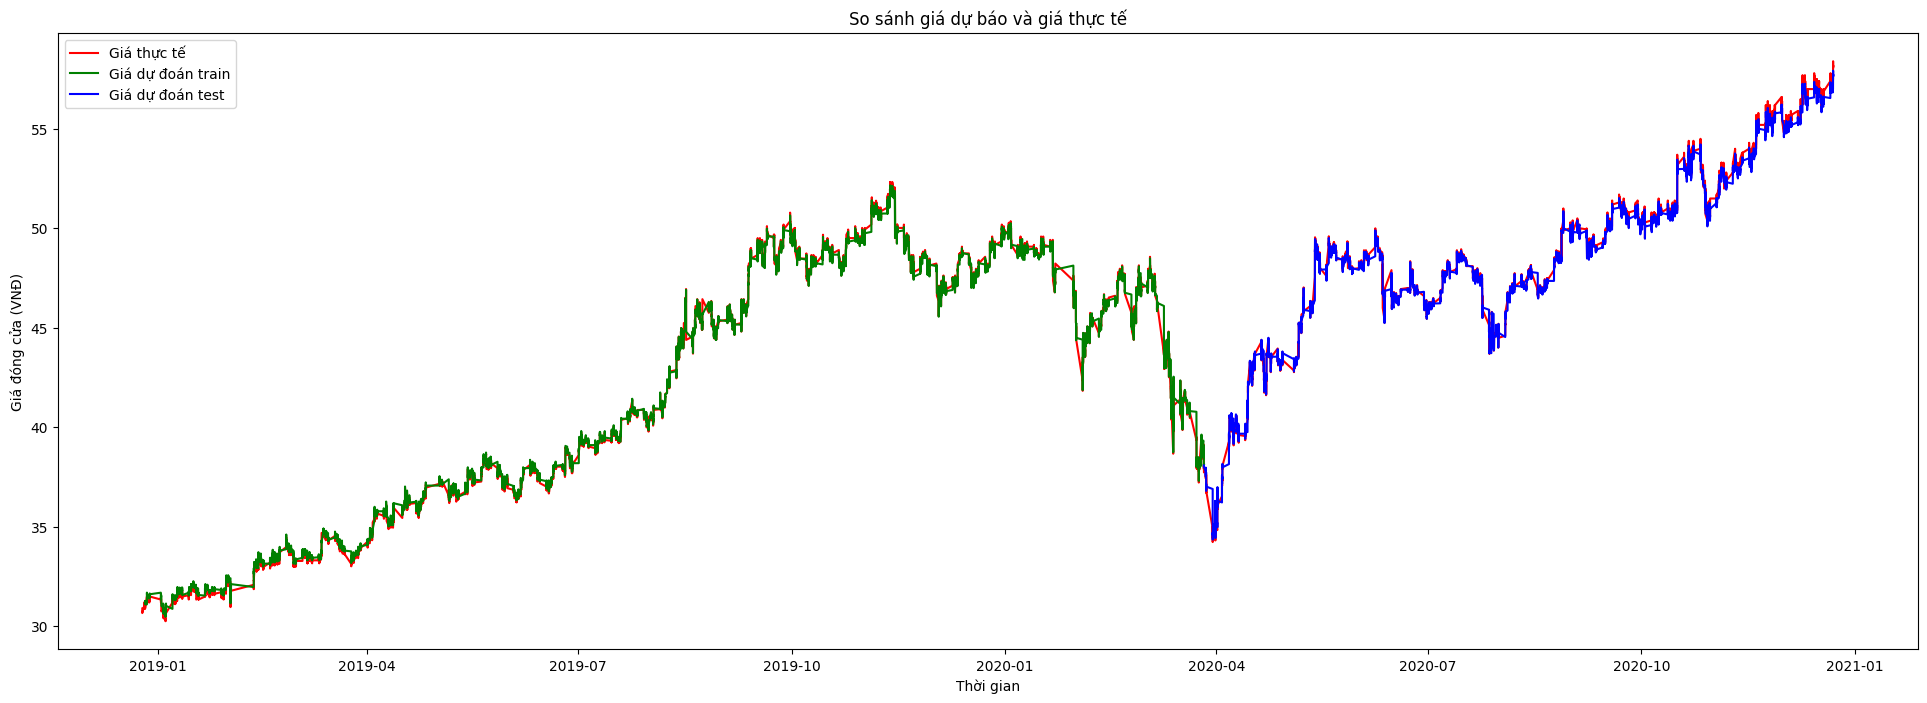

In [21]:
#lập biểu đồ so sánh
train_data1 = df1[100:57000]
test_data1 = df1[57000:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [22]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9996564522525759
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.0923023453321943
Phần trăm sai số tuyệt đối trung bình tập train: 0.002321131670710258


In [ ]:
train_data1

,Close,Dự đoán
Date/Time,,
2018-12-26 13:22:00,31.00,31.204071
2018-12-26 13:37:00,31.04,31.206316
2018-12-26 13:39:00,31.00,31.247192
2018-12-26 13:41:00,31.04,31.207363
2018-12-26 13:42:00,31.04,31.246336
...,...,...
2020-03-26 14:22:00,38.03,38.116924
2020-03-26 14:23:00,38.03,38.118080
2020-03-26 14:24:00,38.03,38.117176


In [23]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9986231935291067
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.12408262217592993
Phần trăm sai số tuyệt đối trung bình tập test: 0.0024238643672819917


In [ ]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-03-26 14:27:00,37.99,38.081188
2020-03-26 14:28:00,37.99,38.075710
2020-03-26 14:29:00,37.90,38.074432
2020-03-26 14:46:00,37.73,37.990398
2020-03-27 09:15:00,37.90,37.824390
...,...,...
2020-12-22 14:24:00,58.20,57.708271
2020-12-22 14:25:00,58.20,57.731285
2020-12-22 14:26:00,58.20,57.741398


# Thử dự đoán giá tương lai  sau N phút và so sánh với giá ngày cuối

Nhập số phút dự đoán: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


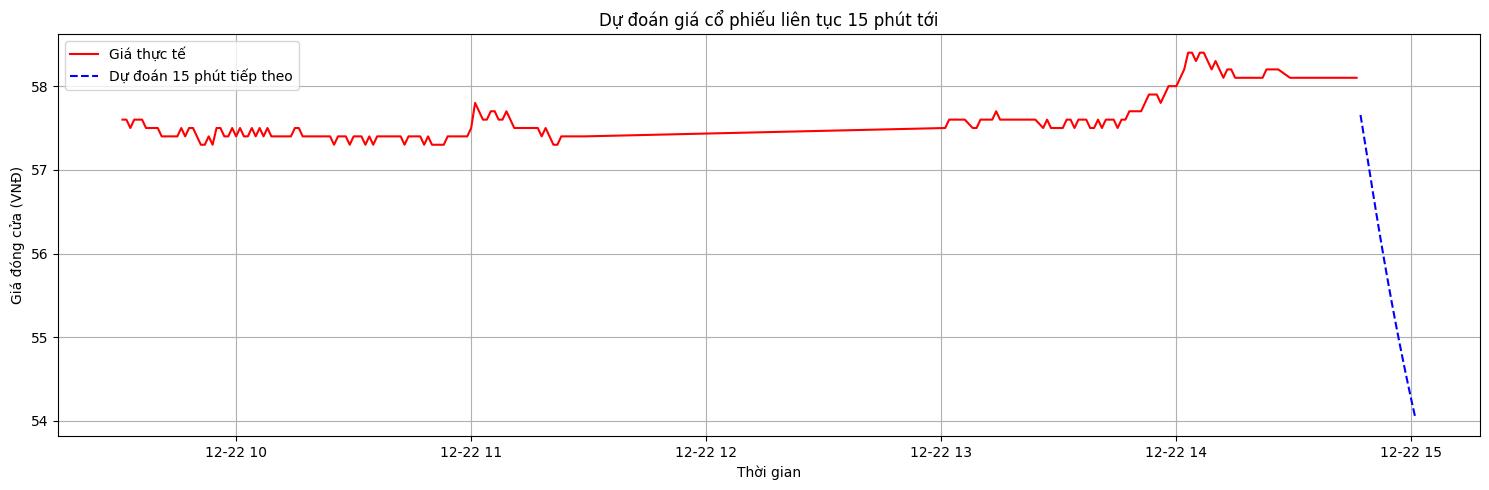

Biến động sau 15 phút: [-4.06420288]


<ipython-input-24-efbf7403bc50>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Biến động sau {} phút: {}'.format(n,(predicted_prices[-1]-df1['Close'][-1])))


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n = int(input("Nhập số phút dự đoán: "))

# Lấy 100 giá gần nhất và chuẩn hóa
input_seq = df1['Close'].values[-100:].reshape(-1, 1)
input_seq = sc.transform(input_seq)

predicted_prices = []
future_times = []

# Thời điểm bắt đầu
last_time = df1.index[-1]

for i in range(n):
    x_input = np.array([input_seq.flatten()])
    x_input = x_input.reshape(1, 100, 1)

    # Dự đoán
    y_pred = final_model.predict(x_input)
    predicted_prices.append(y_pred[0][0])

    # Cập nhật chuỗi đầu vào
    input_seq = np.append(input_seq, y_pred)[-100:].reshape(-1, 1)

    # Thêm thời gian tương ứng
    future_times.append(last_time + pd.Timedelta(minutes=i+1))

# Chuyển kết quả về giá trị gốc
predicted_prices = sc.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(df1.index[-200:], df1['Close'][-200:], label='Giá thực tế', color='red')
plt.plot(future_times, predicted_prices, label='Dự đoán {} phút tiếp theo'.format(n), color='blue', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Dự đoán giá cổ phiếu liên tục {} phút tới'.format(n))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print('Biến động sau {} phút: {}'.format(n,(predicted_prices[-1]-df1['Close'][-1])))